# KIT wide type dataset and benchmarks
- [Dataset](#dataset)
- [Benchmark](#benchmark)

- **KIT** **(Proto-oncogene c-KIT)** receptor plays a crucial role in regulating cell growth, differentiation, and survival. It's particularly important in the development of blood cells, melanocytes (the cells that produce melanin, the pigment responsible for skin, hair, and eye color), and certain cells in the gut.
    
    Mutations in the KIT gene can lead to uncontrolled cell growth and contribute to the development of certain types of cancer, including gastrointestinal stromal tumors (GISTs) and some types of leukemia.
    
    KIT proto-oncogene, receptor tyrosine kinase, is a transmembrane receptor tyrosine kinase (PMID: 32214210) that binds the stem cell factor (SCF) ligand to activate PI3K, JAK/STAT, and MAPK pathways to promote cell survival and proliferation (PMID: 23181448, PMID: 29704617). Activating Kit mutations are driver mutations in a variety of cancers, particularly in gastrointestinal stromal tumors (PMID: 23127174, PMID: 29704617, PMID: 32091431), acute myeloid leukemia (PMID: 32008291), melanomas (PMID: 30707374, PMID: 32608199), and seminomas (PMID: 29704617).
    
    - **KIT wild type**:  
    In certain cancers, KIT signaling can be activated by other receptors or mutations upstream in the signaling pathway. Targeting these upstream factors can indirectly impact KIT signaling and downstream effects. An example of this is seen in some cases of acute myeloid leukemia (AML) where KIT is expressed without mutations, but other upstream mutations can lead to aberrant KIT activation.
    - **KIT selectivity**: This dataset includes KIT wild type and reported mutants `KIT T6701`, `KIT V560G`. D816V results in constitutive phosphorylation of Kit, activation of Stat5 signaling (PMID: 19865100, PMID: 18390729), induces mastocytosis and tumor formation in mice (PMID: 21148330) and confers resistance to Kit inhibitors (PMID: 22301675, PMID: 19164557).

**Published RET datasets**: 
- **PKIS 1**: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis. [ref]

**Description of readout:**
- **Readouts**:  `KIT_(T670I_mutant)`, `KIT_(V560G_mutant)`, `KIT`
- **Bioassay readout**: Percentage of inhnibition.
- **Optimization objective**: Higher the more potent.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import datamol as dm
import pandas as pd
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pathlib
os.chdir(pathlib.Path("__file__").absolute().parents[3])

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from utils import *
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

## Dataset creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <06_KIT_mutants_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [2]:
from polaris.utils.types import HubOwner
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

In [3]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/kinases/kit"
DATASET_DIR = "gs://polaris-public/datasets/kinases/kit"
FIGURE_DIR = "gs://polaris-public/datasets/kinases/kit/figures"

**Create the KIT dataset with `polaris.Dataset`** 

In [4]:
# Load data
PATH = 'gs://polaris-public/Data/kinases/KIT_mutants_curated.parquet'
table = pd.read_parquet(PATH)

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecules structures and identifiers in dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when is needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [5]:
data_cols = ['KIT_(T6701_mutant)', 'KIT_(V560G_mutant)', 'KIT']
th = 75

In [6]:
annotations = {
     'UNIQUE_ID': ColumnAnnotation(protocol='Molecular hash ID. See <datamol.mol.hash_mol>'),
     'smiles': ColumnAnnotation(protocol='Molecule SMILES string'),
     'KIT_(T6701_mutant)': ColumnAnnotation(protocol='Percentage of inhibition on KIT with mutation Y791F mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'T6701_mutant', 'target': 'KIT'}),
     'KIT_(V560G_mutant)': ColumnAnnotation(protocol='Percentage of inhibition on KIT with mutation Y791F mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'V560G_mutant', 'target': 'KIT'}), 
     'KIT': ColumnAnnotation(protocol='Percentage of inhibition on KIT wide type', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'https://pubmed.ncbi.nlm.nih.gov/26501955', 'mutation': 'None', 'target': 'EGFR'}),
     'CLASS_KIT_(T6701_mutant)': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on KIT V804L mutant', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'KIT_(T6701_mutant)'}),
     'CLASS_KIT_(V560G_mutant)': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on KIT Y791F mutant', user_attributes={'thresholds':  f'[{th}]', 'label_order': 'ascending', 'ref_col': 'KIT_(V560G_mutant)'}),
     'CLASS_KIT': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on KIT wide type', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'KIT'})
}

### Create `Dataset` object

In [7]:
dataset_name= "drewry_kit_wt_t670i_v560g_v1"

In [8]:
dataset = Dataset(
    table=table[annotations.keys()],
    name=dataset_name,
    description=f"Profile of kinase KIT, and its mutants KIT, KIT_(T6701_mutant), KIT_(V560G_mutant).",
    source="https://pubmed.ncbi.nlm.nih.gov/26501955",
    annotations=annotations,
    owner=owner, 
    tags=["Kinase","HitDiscovery", "Selectivity"],
   readme=load_readme(f"gs://polaris-public/datasets/readmes/{dataset_name}_readme.md")
)

In [9]:
# save the dataset
SAVE_DIR = f"{DATASET_DIR}/{dataset_name}"
dataset.to_json(SAVE_DIR)

'gs://polaris-public/datasets/kinases/kit/drewry_kit_wt_t670i_v560g_v1/dataset.json'

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

### Create scaffold split for `KIT` dataset
> **Note:**
> Here we use splitting tool `Splito` to split dataset to train and test. \
> [Splito](https://github.com/datamol-io/splito) is a machine learning dataset splitting library for life sciences.

The objective is to comprehend the proficiency of a model in predicting these 'easy' properties. \
In order to select the predictive models which is able to generalize to new chemical space, a scaffold split is used to generate trian/test sets. 

In [10]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit
flag = True
TEST_SIZE = 0.2
SEED = 780
splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
scaffold_split = next(splitter.split(X=dataset.table.smiles.values))

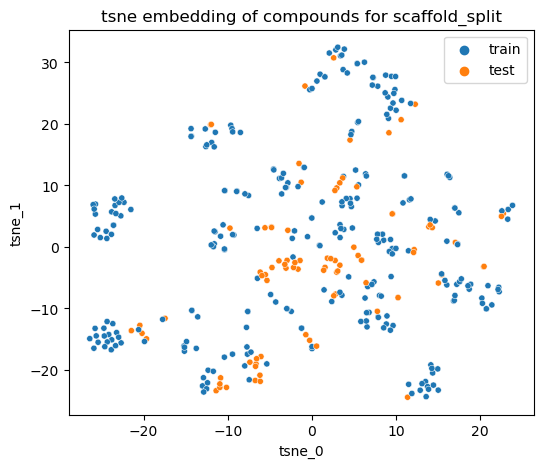

In [11]:
from utils import display_umap
fig = display_umap(table, 'smiles', split =scaffold_split, 
                   split_name="scaffold_split")
save_figure(fig,remote_path=f"{FIGURE_DIR}/{dataset_name}_umap_scaffold_split.png", 
            local_path=f"figures/{dataset_name}_umap_scaffold_split.png" )

## Multitask for all the KIT endpoints with a common random split. 

**Regression**

In [12]:
benchmark_name =f"drewry_kit_wt_t670i_v560g_multitask_reg_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"


benchmark_reg = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="mean_squared_error",
    metrics=["mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var"], 
    tags=["Kinase", "MultiTask", "Regression", "HitDiscovery"],
    owner =owner, 
    description="Multitask regression benchmark for KIT wild type and T6701 and V56G mutant.",
    readme=load_readme(f"gs://polaris-public/benchmarks/readmes/{benchmark_name}_readme.md")

)
path = benchmark_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/kit/drewry_kit_wt_t670i_v560g_multitask_reg_v1/benchmark.json


**Classification**

In [13]:
data_cols = ['CLASS_KIT_(T6701_mutant)', 'CLASS_KIT_(V560G_mutant)', 'CLASS_KIT']
benchmark_name =f"drewry_kit_wt_t670i_v560g_multitask_clf_v1"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"

benchmark_clf = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    main_metric="f1_macro",
    metrics=["accuracy", "f1_macro", "roc_auc", "pr_auc", "mcc", "cohen_kappa"],
    tags=["Kinase", "MultiTask", "Classification", "HitDiscovery"], 
    owner=owner,
    description="Multitask classification benchmark for KIT wild type and T6701 and V56G mutant.",
    readme=load_readme(f"gs://polaris-public/benchmarks/readmes/{benchmark_name}_readme.md")
)
path = benchmark_clf.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/kinases/kit/drewry_kit_wt_t670i_v560g_multitask_clf_v1/benchmark.json
